# Stock Returns

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def get_stock_data(symbol,period='max'):
    stock_df = pd.DataFrame(yf.Ticker(symbol).history(period=period))
    #yfinance returns adj close as close automatically
    stock_df = stock_df.rename(columns={'Close':'Adj_Close'})
    stock_df['Daily_Returns'] = (stock_df['Adj_Close'] + stock_df['Dividends'] - stock_df['Adj_Close'].shift(1))/stock_df['Adj_Close'].shift(1)
    expected_return = stock_df['Daily_Returns'].mean()
    volatility = stock_df['Daily_Returns'].std()
    return stock_df, expected_return, volatility

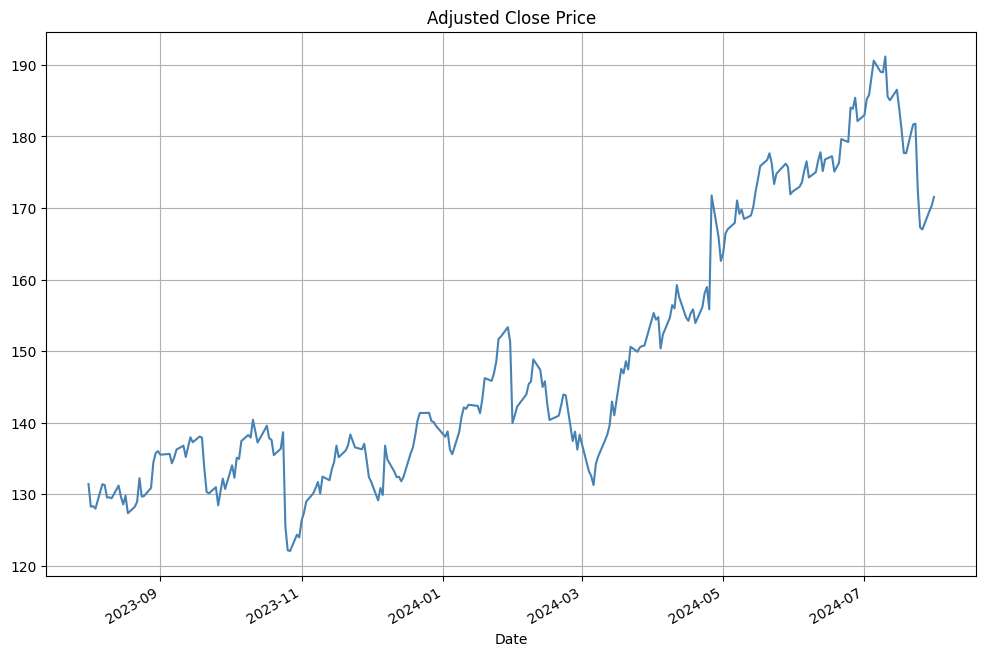

Volatility: 1.73%


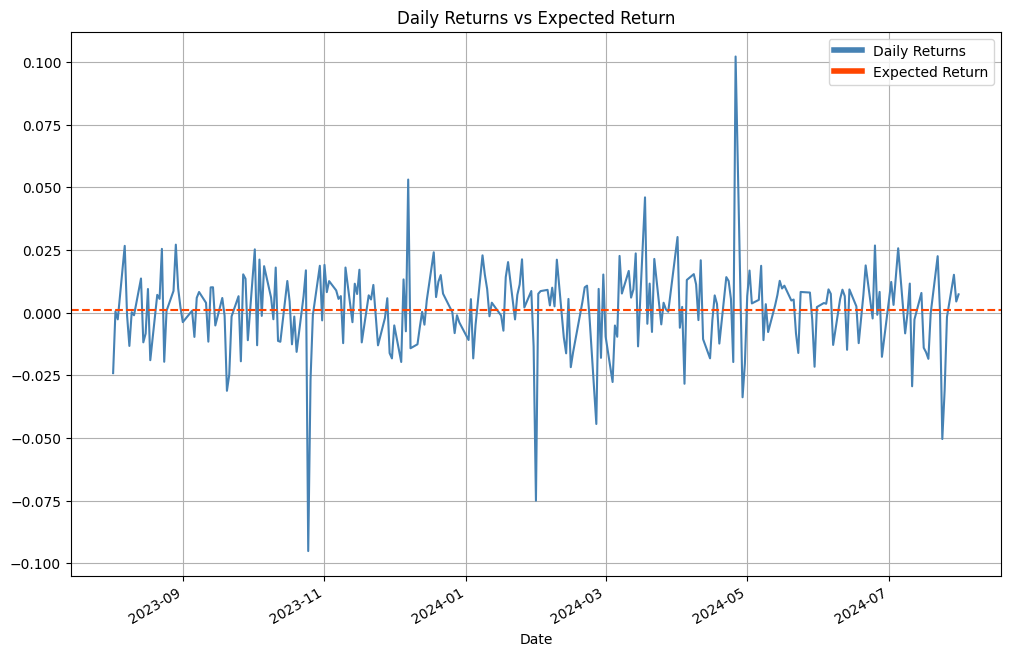

In [3]:
stock_df,expected_return,volatility = get_stock_data('GOOGL', '1y')
colors = ['steelblue','orangered']
stock_df['Adj_Close'].plot(figsize=(12,8), color = colors[0])
plt.title('Adjusted Close Price')
plt.grid()
plt.show()
print(f"Volatility: {volatility*100:.2f}%")
ax = stock_df['Daily_Returns'].plot(figsize=(12,8), color = colors[0])
plt.axhline(y=expected_return, color=colors[1], linestyle='--')
custom_lines = [Line2D([0], [0], color=colors[0], lw=4), Line2D([0], [0], color=colors[1], lw=4)]
ax.legend(custom_lines, ['Daily Returns','Expected Return'])
plt.title('Daily Returns vs Expected Return')
plt.grid()
plt.show()

